Author: Victor Shih  
Date: 2 February 2023

Imports

In [1]:
import torch
from torch import nn
from torch.optim.lr_scheduler import ReduceLROnPlateau, StepLR

import torchvision
from torchvision import transforms, datasets
from torchvision.models import resnet18, ResNet18_Weights

import numpy as np

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import os

from itertools import product

print(torch.__version__)
print(torch.cuda.is_available())

1.13.1
True


# Dataset

What does the raw data look like?

- For this hymenoptera dataset, the images are arranged in the folder corresponding to their label.
    
    i.e., `root/ants/xxx.png`  
    `root/bees/asdf.png`
    
    Therefore, torchvision.datasets.ImageFolder was used to perform data loading.

## Loading data

Before creating the data loaders, all the images were first transformed into tensors using `transforms.ToTensor()`. Both the datasets and dataloaders were saved to dictionaries to streamline the training and testing code.

In [2]:
batch_size = 32
raw_dataset = {a: datasets.ImageFolder(root=f'data/hymenoptera_data/{a}', transform=transforms.ToTensor()) 
               for a in ['train', 'val']}
raw_dataloader = {a: torch.utils.data.DataLoader(dataset=raw_dataset[a], batch_size=batch_size, shuffle=True)
                  for a in ['train', 'val']}

## Data augmentation

After loading the raw data, we then performed the same data preprocessing operations that resnet18 used for its data. https://pytorch.org/vision/main/models/generated/torchvision.models.resnet18.html#torchvision.models.ResNet18_Weights

In [3]:
class MyDataset(torch.utils.data.Dataset):
    def __init__(self, subset, transform=None):
        self.subset = subset
        self.transform = transform
        
    def __getitem__(self, index):
        x, y = self.subset[index]
        if self.transform:
            x = self.transform(x)
        return x, y
        
    def __len__(self):
        return len(self.subset)
    
my_preprocess = {
    'train': transforms.Compose([
        # transforms.Resize(size=256, interpolation=transforms.InterpolationMode.BILINEAR),
        # transforms.CenterCrop(size=[224]),
        # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

        transforms.Resize(size=256, interpolation=transforms.InterpolationMode.BILINEAR),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(size=256, interpolation=transforms.InterpolationMode.BILINEAR),
        transforms.CenterCrop(size=[224]),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
}
# Augmented data.
dataset = {a: MyDataset(raw_dataset[a], transform=my_preprocess[a])
           for a in ['train', 'val']}
dataloader = {a: torch.utils.data.DataLoader(dataset=dataset[a], batch_size=batch_size, shuffle=True)
              for a in ['train', 'val']}

Results of data augmentations:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


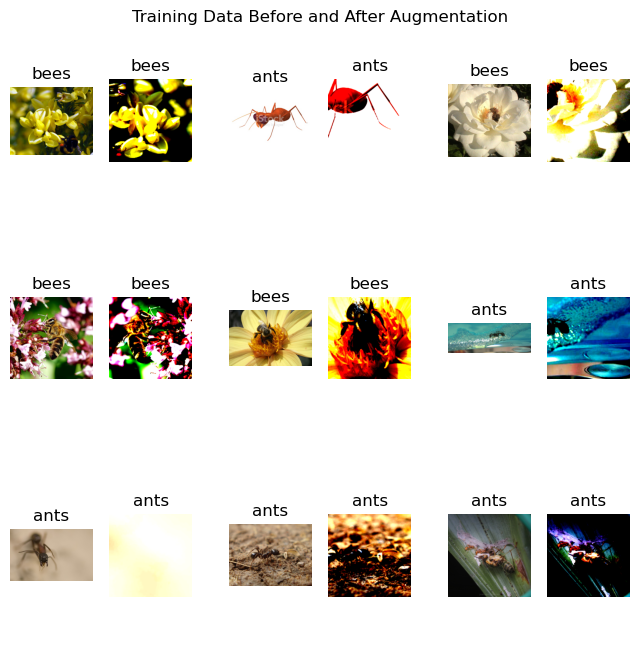

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


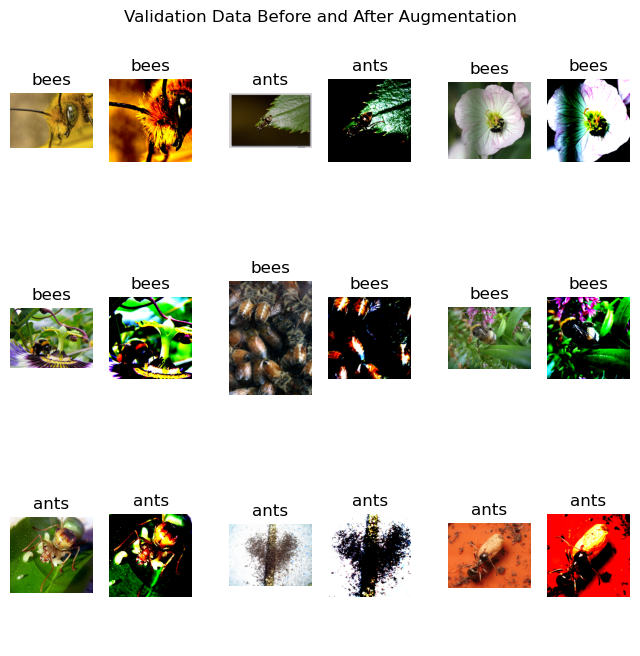

In [4]:
labels_map = {
    0: "ants",
    1: "bees"
}
cols, rows = 3, 3
for a in ['train', 'val']:
    figure = plt.figure(figsize=(8, 8))
    plt.axis("off")
    if a == 'train': plt.title("Training Data Before and After Augmentation")
    else: plt.title("Validation Data Before and After Augmentation")
    gs0 = gridspec.GridSpec(3, 3, figure=figure)
    for i in range(1, cols * rows + 1):
        t0=len(raw_dataset[a])
        sample_idx = torch.randint(t0, size=(1,)).item()
        raw_img, raw_label = raw_dataset[a][sample_idx]
        img_after, label_after = dataset[a][sample_idx]

        gs = gridspec.GridSpecFromSubplotSpec(1, 2, subplot_spec=gs0[i-1])

        figure.add_subplot(gs[0])
        plt.axis("off")
        plt.imshow(raw_img.movedim(0, -1))
        plt.title(labels_map[raw_label])

        figure.add_subplot(gs[1])
        plt.axis("off")
        plt.imshow(img_after.movedim(0, -1))
        plt.title(labels_map[label_after])
    
    plt.show()

In [5]:
dataset_sizes = {x: len(dataset[x]) for x in ['train', 'val']}

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Loading data from data/hymenoptera_data/")
print(f"Dataset sizes: train = {dataset_sizes['train']}, val = {dataset_sizes['val']}")
sample, label = dataset['train'][0]
print(f"Shape of samples: {sample.shape}")

print(f"Using {device} device.")

Loading data from data/hymenoptera_data/
Dataset sizes: train = 244, val = 153
Shape of samples: torch.Size([3, 224, 224])
Using cuda:0 device.


# Models

In [6]:
from torchinfo import summary

model_resnet18 = resnet18(weights='DEFAULT')
num_ftrs = model_resnet18.fc.in_features
model_resnet18.fc = nn.Linear(num_ftrs, 2)
model_resnet18.to(device)
summary(model_resnet18, input_size=(batch_size, 3, 224, 224))


Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   [32, 2]                   --
├─Conv2d: 1-1                            [32, 64, 112, 112]        9,408
├─BatchNorm2d: 1-2                       [32, 64, 112, 112]        128
├─ReLU: 1-3                              [32, 64, 112, 112]        --
├─MaxPool2d: 1-4                         [32, 64, 56, 56]          --
├─Sequential: 1-5                        [32, 64, 56, 56]          --
│    └─BasicBlock: 2-1                   [32, 64, 56, 56]          --
│    │    └─Conv2d: 3-1                  [32, 64, 56, 56]          36,864
│    │    └─BatchNorm2d: 3-2             [32, 64, 56, 56]          128
│    │    └─ReLU: 3-3                    [32, 64, 56, 56]          --
│    │    └─Conv2d: 3-4                  [32, 64, 56, 56]          36,864
│    │    └─BatchNorm2d: 3-5             [32, 64, 56, 56]          128
│    │    └─ReLU: 3-6                    [32, 64, 56, 56]          --
│

# Tensorboard?

In [7]:
t0 = torch.tensor([[0.1, 1.2], [2.2, 3.1], [4.9, 5.2]]) # shape=(3, 2)
t3 = torch.tensor([[0.1, 1.1, 2.1], [10, 11, 12]]) # [2,3]
t1 = torch.tensor([1, 2, 3]) # shape=(3)
t1_new = t1[:, None] # shape=(3, 1)
t1_new2 = t1[None, :]
result = torch.mul(t0, t1_new) # 3 is broadcast to 3
result2 = torch.add(t0, t1_new)

result_1 = torch.mul(t3, t1)
result_2 = torch.mul(t3, t1_new2)
print()

In [8]:
from torch.utils.tensorboard import SummaryWriter

# Writer will output to ./runs/ directory by default
writer = SummaryWriter()
images, labels = next(iter(dataloader['train']))
# images, labels = next(iter(raw_dataloader['train']))
# images = images.to("cuda:0", torch.uint8)
# transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

images_size = images.size() # [32, 3, 224, 224]
mean = torch.tensor([0.485, 0.456, 0.406])
mean = mean[None, :, None, None] # shape=[1,3,1,1]
std = torch.tensor([0.229, 0.224, 0.225])
std = std[None, :, None, None] # shape=[1,3,1,1]
images = torch.mul(images, std)
images = torch.add(images, mean)
images = images.to("cuda:0")
# t0 = torch.mul(images, [0.229, 0.224, 0.225])
# t1 = torch.add(t0, [0.485, 0.456, 0.406])

grid = torchvision.utils.make_grid(images)
writer.add_image("images", grid)
writer.add_graph(model_resnet18, images)
writer.close()


# Training and Validation

In [9]:
# layout = {
#     "ABCDE": {
#         "loss": ["Multiline", ["Train Loss", "Val Loss"]],
#         "accuracy": ["Multiline", ["Train Accuracy", "Val Accuracy"]],
#     },
# }
# writer = SummaryWriter()
# writer.add_custom_scalars(layout)

history_dict = {'train loss':[], 'train accuracy':[], 'val loss':[], 'val accuracy':[]}

In [10]:
def train(dataloader, model, loss_fn, optimizer, epoch):
    size = len(dataloader.dataset) # Num of samples.
    num_batches = len(dataloader) # Num of batches.
    model.train() # set model to training mode.
    epoch_loss, correct = 0, 0 # avg loss of the current epoch.
    current = 0
    for batch, (X, y) in enumerate(dataloader): # FP and BP each batch of data.
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X) # 
        loss = loss_fn(pred, y) #

        # Log stuff to tensorboard. (batch wide)
        
        # Backpropagation
        optimizer.zero_grad() # https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch
        loss.backward() #
        optimizer.step() #

        epoch_loss += loss.item()
        correct += (pred.argmax(1) == y).type(torch.float).sum().item()
        
        # if batch % 100 == 0:
        #     loss, current = loss.item(), batch * len(X)
        #     print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
        # if batch % 4 == 0:
        t0 = len(X)
        loss, current = loss.item(), current + t0
        # loss, current = loss.item(), batch * len(X)
        print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
        
        
    epoch_loss /= num_batches
    accuracy = (correct/size)*100
    history_dict['train loss'].append(epoch_loss)
    history_dict['train accuracy'].append(accuracy)
    
    # Log stuff to tensorboard. (epoch wide)
    writer.add_scalar("Train Loss", epoch_loss, epoch)
    writer.add_scalar("Train Accuracy", accuracy, epoch)


In [11]:
test_loss = 0.0
best_acc = 0.0
curr_acc = 0.0
def test(dataloader, model, loss_fn, epoch):
    '''
    Returns test accuracy.
    '''
    global test_loss
    global best_acc
    global curr_acc

    size = len(dataloader.dataset) # Num of samples in the dataset.
    num_batches = len(dataloader) # Num of batches.
    model.eval()
    # test_loss, curr_acc, correct = 0, 0, 0
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader: # X, y contain all the samples in the current batch.
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
            
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f}")
    curr_acc = 100*correct
    history_dict['val loss'].append(test_loss)
    history_dict['val accuracy'].append(100*correct)

    writer.add_scalar("Val Loss", test_loss, epoch)
    writer.add_scalar("Val Accuracy", curr_acc, epoch)

In [12]:
def train_test_loop(model_name, save, epochs, model, loss_fn, optimizer, scheduler, lr, batch_size, shuffle, run_id):
    global test_loss
    global best_acc
    global curr_acc

    epoch = 1
    print("Training\n")
    for i in range(epochs):
        print(f"Epoch {i}\n-------------------------------")
        train(dataloader=dataloader['train'], model=model, loss_fn=loss_fn, optimizer=optimizer, epoch=i)
        test(dataloader=dataloader['val'], model=model, loss_fn=loss_fn, epoch=i)

        for name, weight in model.named_parameters():
            writer.add_histogram(name, weight, epoch)
            writer.add_histogram(f"{name}.grad", weight.grad, epoch)

        if curr_acc > best_acc:
            best_acc = curr_acc
            # if not os.path.exists(f'models/'):
            #     os.makedirs(f'models/')
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': test_loss,
                'acc': best_acc
            }, f"models/{model_name}")
            print(f"Saved model at Epoch: {epoch}, Test Acc: {best_acc}, to models/{model_name} \n")
        scheduler.step()
        # scheduler.step(test_loss)
        epoch+=1

    print("Training done!\n")

    %matplotlib inline
    plot_Acc_And_Loss(model_name, history_dict, save)
    print("Plots saved.\n")

    # # model.load_state_dict(torch.load(f"models/{MODEL_NAME}"))
    # checkpoint = torch.load(f"models/{model_name}")
    # model.load_state_dict(checkpoint['model_state_dict'])
    # optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    # epoch = checkpoint['epoch']
    # loss = checkpoint['loss']

    writer.add_hparams(
            {"lr": lr, "bsize": batch_size, "shuffle":shuffle},
            {
                "val_accuracy": best_acc,
                "val_loss": test_loss,
            },
        )
    # classes = [
    # "T-shirt/top",
    # "Trouser",
    # "Pullover",
    # "Dress",
    # "Coat",
    # "Sandal",
    # "Shirt",
    # "Sneaker",
    # "Bag",
    # "Ankle boot",
    # ]

    # model.eval()
    # for sample in range(0, 10):
    #     x, y = test_data[sample][0], test_data[sample][1] # get 1st sample and corresponding label.
    #     with torch.no_grad():
    #         x = torch.unsqueeze(x, 0)
    #         pred = model(x.to(device))
    #         predicted, actual = classes[pred[0].argmax(0)], classes[y]
    #         print(f'Predicted: "{predicted}", Actual: "{actual}"')

# Temp Plotting Function (Placeholder. This will be replaced by Tensorboard.)

In [13]:
import matplotlib.pyplot as plt 
import os

def plot_Acc_And_Loss(model_name, history_dict, save=True):
    """
    Plots loss and accuracy of train and val data over epochs.
    :return:
    """
    plt.plot(history_dict['train accuracy'])
    plt.plot(history_dict['val accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    if save: 
        if not os.path.exists(f'model_logs/{model_name}_logs/'):
            os.makedirs(f'model_logs/{model_name}_logs/')
        plt.savefig(f'model_logs/{model_name}_logs/{model_name}_accuracy.png')
    plt.show()

    plt.plot(history_dict['train loss'])
    plt.plot(history_dict['val loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    if save: 
        if not os.path.exists(f'model_logs/{model_name}_logs/'):
            os.makedirs(f'model_logs/{model_name}_logs/')
        plt.savefig(f'model_logs/{model_name}_logs/{model_name}_loss.png')
    plt.show()

# Train and Validate

Hyperparameters

In [14]:
epochs = 20
# lr = 1e-3

parameters = {
    'lr' : [1e-5, 1e-4, 1e-3],
    'batch_size' : [32, 64, 128],
    'shuffle' : [True]
}

parameter_vals = [a for a in parameters.values()]
print(parameter_vals)

t0 = product(*parameter_vals)
for lr, batch_size, shuffle in t0:
    print(lr, batch_size, shuffle)

[[1e-05, 0.0001, 0.001], [32, 64, 128], [True]]
1e-05 32 True
1e-05 64 True
1e-05 128 True
0.0001 32 True
0.0001 64 True
0.0001 128 True
0.001 32 True
0.001 64 True
0.001 128 True


RUN ID: 1, lr:1e-05, bsize:32, shuffle:True
Training

Epoch 0
-------------------------------
loss: 0.717715  [   32/  244]
loss: 0.690674  [   64/  244]
loss: 0.636924  [   96/  244]
loss: 0.624612  [  128/  244]
loss: 0.696700  [  160/  244]
loss: 0.795635  [  192/  244]
loss: 0.791882  [  224/  244]
loss: 0.671746  [  244/  244]
Test Error: 
 Accuracy: 59.5%, Avg loss: 0.686369
Saved model at Epoch: 1, Test Acc: 59.47712418300654, to models/resnet18_RUNID_1_lr_1e-05_bsize_32_shuffle_True 

Epoch 1
-------------------------------
loss: 0.625008  [   32/  244]
loss: 0.656061  [   64/  244]
loss: 0.603685  [   96/  244]
loss: 0.684635  [  128/  244]
loss: 0.675019  [  160/  244]
loss: 0.692988  [  192/  244]
loss: 0.722308  [  224/  244]
loss: 0.656357  [  244/  244]
Test Error: 
 Accuracy: 58.2%, Avg loss: 0.691675
Epoch 2
-------------------------------
loss: 0.677114  [   32/  244]
loss: 0.646689  [   64/  244]
loss: 0.779376  [   96/  244]
loss: 0.624409  [  128/  244]
loss: 0.7373

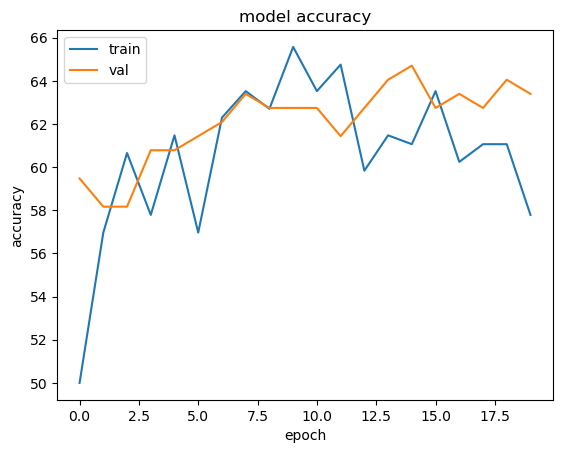

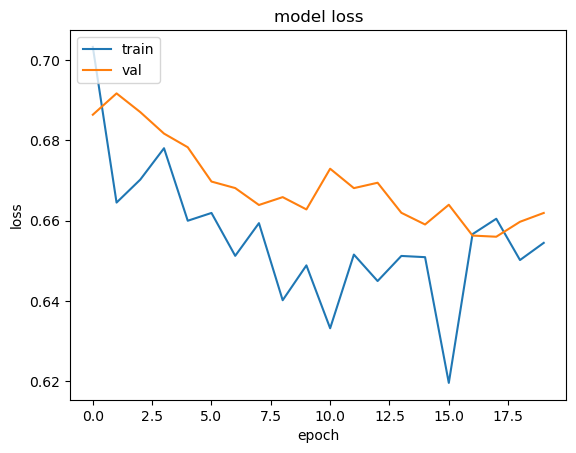

Plots saved.

RUN ID: 2, lr:1e-05, bsize:64, shuffle:True
Training

Epoch 0
-------------------------------
loss: 0.674849  [   64/  244]
loss: 0.613540  [  128/  244]
loss: 0.654623  [  192/  244]
loss: 0.622176  [  244/  244]
Test Error: 
 Accuracy: 63.4%, Avg loss: 0.663018
Epoch 1
-------------------------------
loss: 0.651453  [   64/  244]
loss: 0.682783  [  128/  244]
loss: 0.619873  [  192/  244]
loss: 0.629593  [  244/  244]
Test Error: 
 Accuracy: 63.4%, Avg loss: 0.697073
Epoch 2
-------------------------------
loss: 0.623236  [   64/  244]
loss: 0.642725  [  128/  244]
loss: 0.594305  [  192/  244]
loss: 0.688659  [  244/  244]
Test Error: 
 Accuracy: 62.7%, Avg loss: 0.655871
Epoch 3
-------------------------------
loss: 0.624561  [   64/  244]
loss: 0.635285  [  128/  244]
loss: 0.642957  [  192/  244]
loss: 0.583022  [  244/  244]
Test Error: 
 Accuracy: 64.7%, Avg loss: 0.636218
Epoch 4
-------------------------------
loss: 0.645599  [   64/  244]
loss: 0.624938  [  128

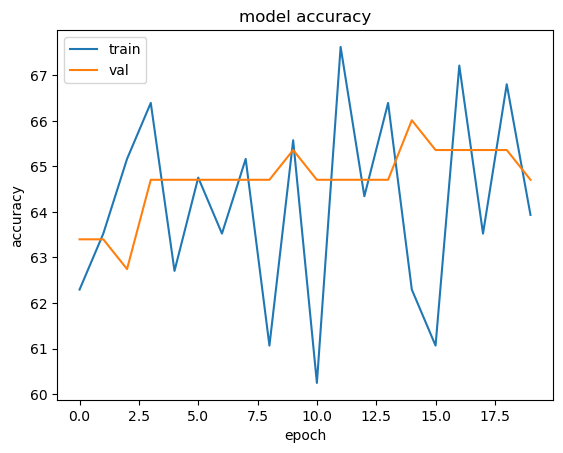

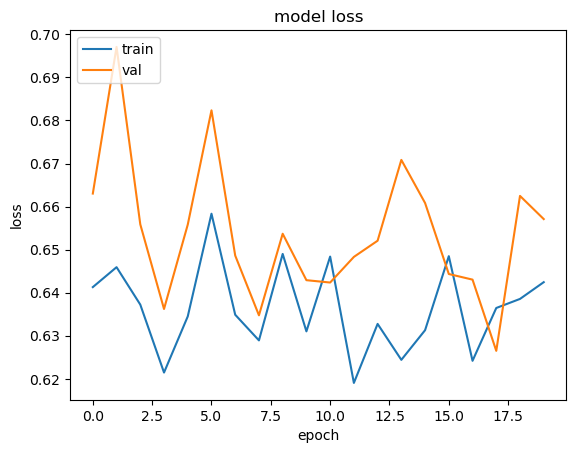

Plots saved.

RUN ID: 3, lr:1e-05, bsize:128, shuffle:True
Training

Epoch 0
-------------------------------
loss: 0.619494  [  128/  244]
loss: 0.665178  [  244/  244]
Test Error: 
 Accuracy: 64.7%, Avg loss: 0.616261
Epoch 1
-------------------------------
loss: 0.637481  [  128/  244]
loss: 0.613209  [  244/  244]
Test Error: 
 Accuracy: 64.7%, Avg loss: 0.634638
Epoch 2
-------------------------------
loss: 0.695067  [  128/  244]
loss: 0.594475  [  244/  244]
Test Error: 
 Accuracy: 65.4%, Avg loss: 0.632843
Epoch 3
-------------------------------
loss: 0.629491  [  128/  244]
loss: 0.638466  [  244/  244]
Test Error: 
 Accuracy: 65.4%, Avg loss: 0.647475
Epoch 4
-------------------------------
loss: 0.590415  [  128/  244]
loss: 0.612444  [  244/  244]
Test Error: 
 Accuracy: 65.4%, Avg loss: 0.651877
Epoch 5
-------------------------------
loss: 0.664082  [  128/  244]
loss: 0.630792  [  244/  244]
Test Error: 
 Accuracy: 64.7%, Avg loss: 0.650632
Epoch 6
-----------------------

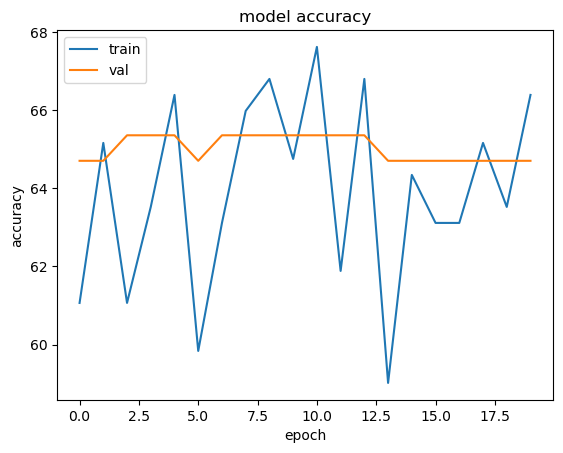

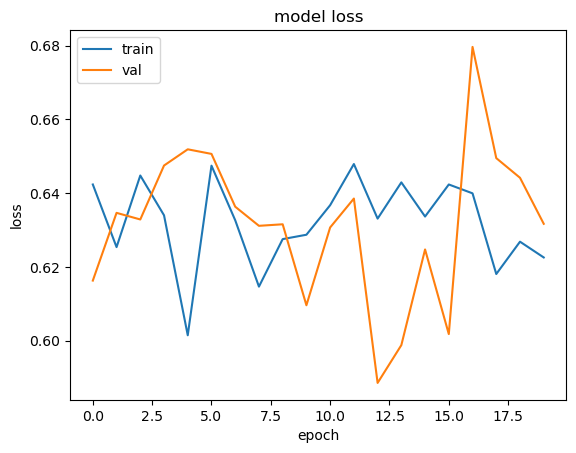

Plots saved.

RUN ID: 4, lr:0.0001, bsize:32, shuffle:True
Training

Epoch 0
-------------------------------
loss: 0.633712  [   32/  244]
loss: 0.701321  [   64/  244]
loss: 0.554764  [   96/  244]
loss: 0.654707  [  128/  244]
loss: 0.547767  [  160/  244]
loss: 0.626808  [  192/  244]
loss: 0.620377  [  224/  244]
loss: 0.652587  [  244/  244]
Test Error: 
 Accuracy: 67.3%, Avg loss: 0.622459
Saved model at Epoch: 1, Test Acc: 67.3202614379085, to models/resnet18_RUNID_4_lr_0.0001_bsize_32_shuffle_True 

Epoch 1
-------------------------------
loss: 0.587492  [   32/  244]
loss: 0.578453  [   64/  244]
loss: 0.636154  [   96/  244]
loss: 0.567464  [  128/  244]
loss: 0.558652  [  160/  244]
loss: 0.663462  [  192/  244]
loss: 0.598429  [  224/  244]
loss: 0.646033  [  244/  244]
Test Error: 
 Accuracy: 71.9%, Avg loss: 0.584056
Saved model at Epoch: 2, Test Acc: 71.89542483660131, to models/resnet18_RUNID_4_lr_0.0001_bsize_32_shuffle_True 

Epoch 2
-------------------------------
lo

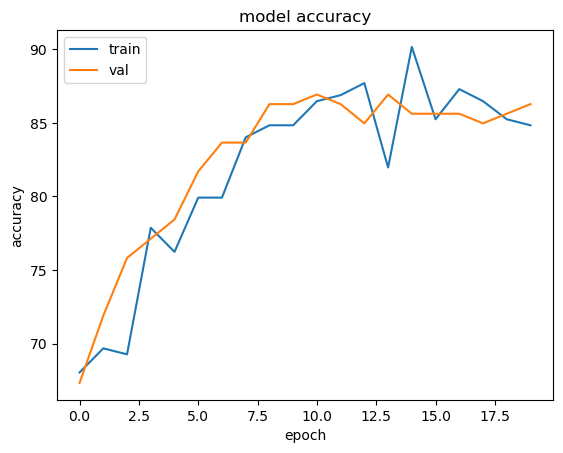

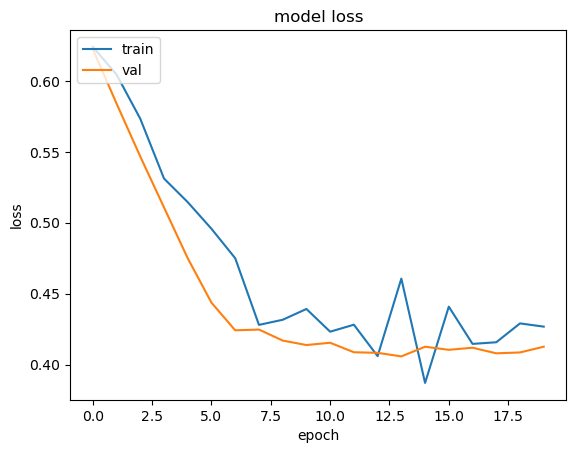

Plots saved.

RUN ID: 5, lr:0.0001, bsize:64, shuffle:True
Training

Epoch 0
-------------------------------
loss: 0.384213  [   64/  244]
loss: 0.404169  [  128/  244]
loss: 0.423338  [  192/  244]
loss: 0.447383  [  244/  244]
Test Error: 
 Accuracy: 86.3%, Avg loss: 0.418818
Epoch 1
-------------------------------
loss: 0.415608  [   64/  244]
loss: 0.440046  [  128/  244]
loss: 0.407664  [  192/  244]
loss: 0.411572  [  244/  244]
Test Error: 
 Accuracy: 85.6%, Avg loss: 0.399929
Epoch 2
-------------------------------
loss: 0.421881  [   64/  244]
loss: 0.464290  [  128/  244]
loss: 0.496982  [  192/  244]
loss: 0.367430  [  244/  244]
Test Error: 
 Accuracy: 85.6%, Avg loss: 0.399636
Epoch 3
-------------------------------
loss: 0.433990  [   64/  244]
loss: 0.397606  [  128/  244]
loss: 0.444752  [  192/  244]
loss: 0.452392  [  244/  244]
Test Error: 
 Accuracy: 86.3%, Avg loss: 0.408009
Epoch 4
-------------------------------
loss: 0.377218  [   64/  244]
loss: 0.401855  [  12

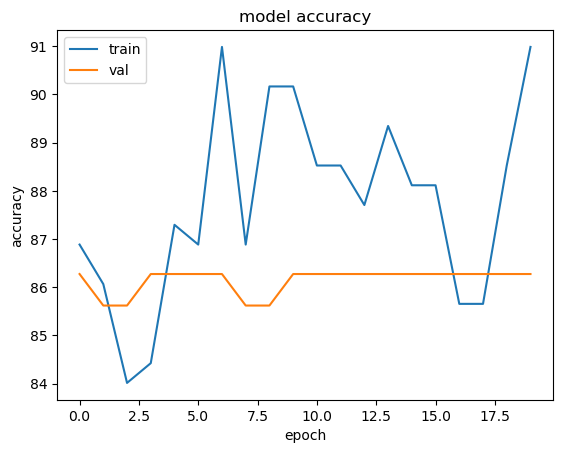

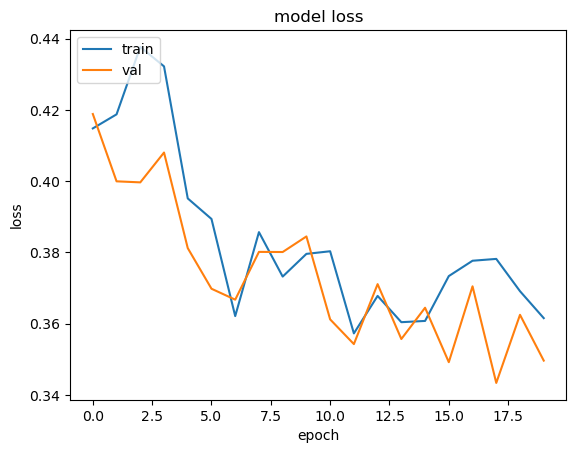

Plots saved.

RUN ID: 6, lr:0.0001, bsize:128, shuffle:True
Training

Epoch 0
-------------------------------
loss: 0.352370  [  128/  244]
loss: 0.405504  [  244/  244]
Test Error: 
 Accuracy: 86.3%, Avg loss: 0.381491
Epoch 1
-------------------------------
loss: 0.377899  [  128/  244]
loss: 0.327935  [  244/  244]
Test Error: 
 Accuracy: 86.3%, Avg loss: 0.347108
Epoch 2
-------------------------------
loss: 0.377102  [  128/  244]
loss: 0.333452  [  244/  244]
Test Error: 
 Accuracy: 86.3%, Avg loss: 0.347910
Epoch 3
-------------------------------
loss: 0.362122  [  128/  244]
loss: 0.380705  [  244/  244]
Test Error: 
 Accuracy: 86.3%, Avg loss: 0.347104
Epoch 4
-------------------------------
loss: 0.367619  [  128/  244]
loss: 0.363189  [  244/  244]
Test Error: 
 Accuracy: 86.3%, Avg loss: 0.396509
Epoch 5
-------------------------------
loss: 0.352242  [  128/  244]
loss: 0.325329  [  244/  244]
Test Error: 
 Accuracy: 86.3%, Avg loss: 0.350759
Epoch 6
----------------------

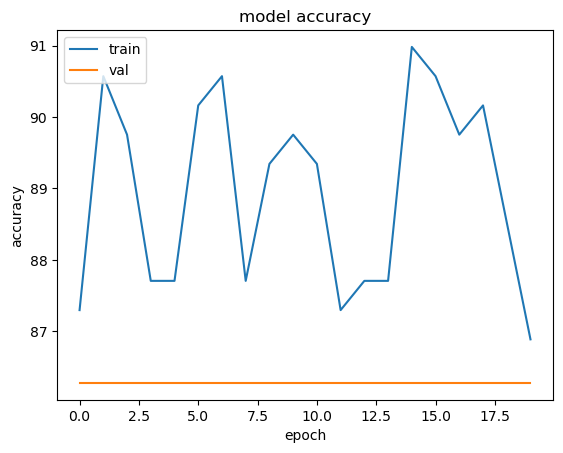

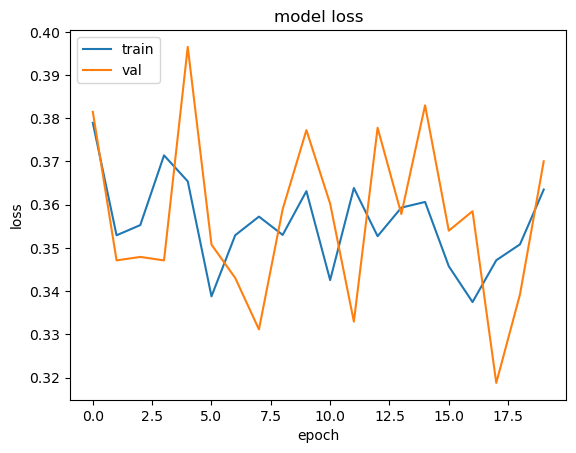

Plots saved.

RUN ID: 7, lr:0.001, bsize:32, shuffle:True
Training

Epoch 0
-------------------------------
loss: 0.362395  [   32/  244]
loss: 0.347587  [   64/  244]
loss: 0.423127  [   96/  244]
loss: 0.274812  [  128/  244]
loss: 0.409665  [  160/  244]
loss: 0.321480  [  192/  244]
loss: 0.415988  [  224/  244]
loss: 0.336467  [  244/  244]
Test Error: 
 Accuracy: 86.9%, Avg loss: 0.311532
Epoch 1
-------------------------------
loss: 0.408185  [   32/  244]
loss: 0.238763  [   64/  244]
loss: 0.241810  [   96/  244]
loss: 0.372943  [  128/  244]
loss: 0.318487  [  160/  244]
loss: 0.264998  [  192/  244]
loss: 0.271522  [  224/  244]
loss: 0.358900  [  244/  244]
Test Error: 
 Accuracy: 92.2%, Avg loss: 0.246700
Saved model at Epoch: 2, Test Acc: 92.15686274509804, to models/resnet18_RUNID_7_lr_0.001_bsize_32_shuffle_True 

Epoch 2
-------------------------------
loss: 0.244584  [   32/  244]
loss: 0.290207  [   64/  244]
loss: 0.257284  [   96/  244]
loss: 0.256112  [  128/  244

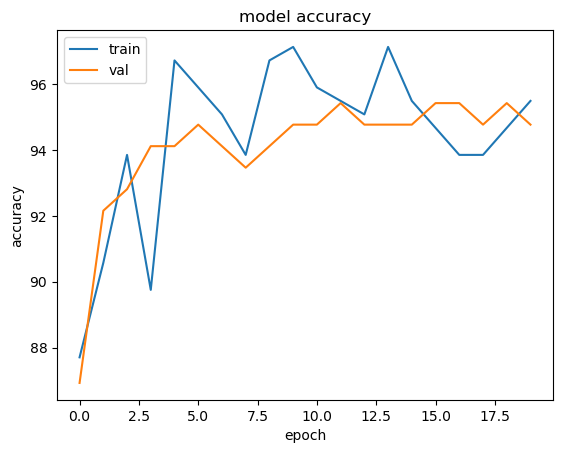

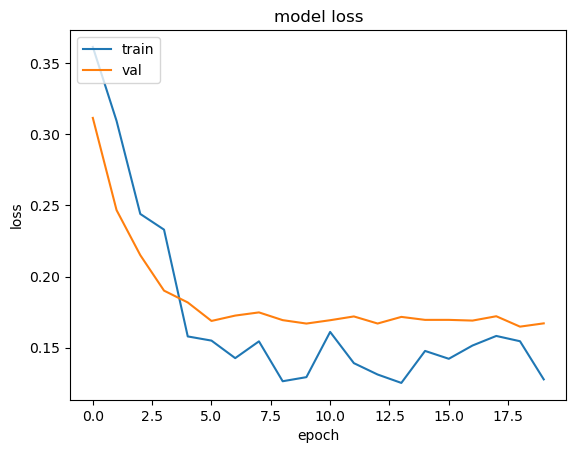

Plots saved.

RUN ID: 8, lr:0.001, bsize:64, shuffle:True
Training

Epoch 0
-------------------------------
loss: 0.077133  [   64/  244]
loss: 0.153494  [  128/  244]
loss: 0.157747  [  192/  244]
loss: 0.099960  [  244/  244]
Test Error: 
 Accuracy: 94.8%, Avg loss: 0.154722
Epoch 1
-------------------------------
loss: 0.110802  [   64/  244]
loss: 0.113871  [  128/  244]
loss: 0.138408  [  192/  244]
loss: 0.145310  [  244/  244]
Test Error: 
 Accuracy: 95.4%, Avg loss: 0.203940
Epoch 2
-------------------------------
loss: 0.083484  [   64/  244]
loss: 0.113797  [  128/  244]
loss: 0.187387  [  192/  244]
loss: 0.131187  [  244/  244]
Test Error: 
 Accuracy: 95.4%, Avg loss: 0.170844
Epoch 3
-------------------------------
loss: 0.077458  [   64/  244]
loss: 0.158272  [  128/  244]
loss: 0.136874  [  192/  244]
loss: 0.060571  [  244/  244]
Test Error: 
 Accuracy: 95.4%, Avg loss: 0.162484
Epoch 4
-------------------------------
loss: 0.112241  [   64/  244]
loss: 0.165500  [  128

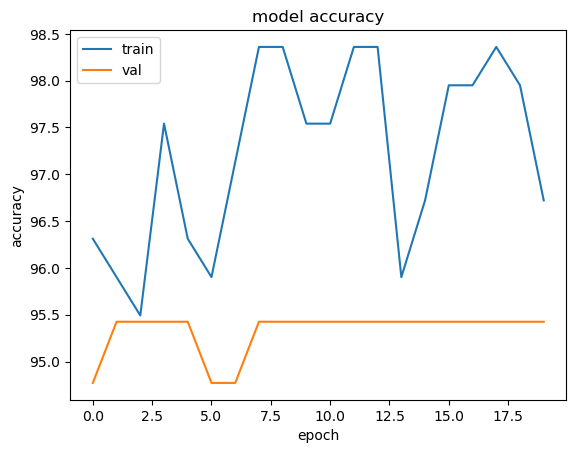

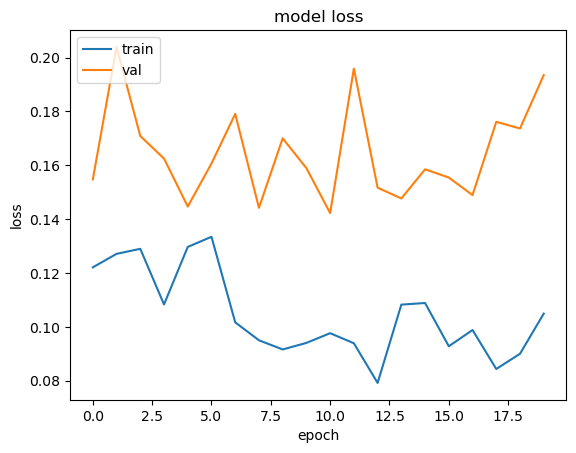

Plots saved.

RUN ID: 9, lr:0.001, bsize:128, shuffle:True
Training

Epoch 0
-------------------------------
loss: 0.059522  [  128/  244]
loss: 0.105459  [  244/  244]
Test Error: 
 Accuracy: 95.4%, Avg loss: 0.183256
Epoch 1
-------------------------------
loss: 0.086371  [  128/  244]
loss: 0.118349  [  244/  244]
Test Error: 
 Accuracy: 95.4%, Avg loss: 0.296100
Epoch 2
-------------------------------
loss: 0.127361  [  128/  244]
loss: 0.103465  [  244/  244]
Test Error: 
 Accuracy: 94.8%, Avg loss: 0.123795
Epoch 3
-------------------------------
loss: 0.115316  [  128/  244]
loss: 0.076036  [  244/  244]
Test Error: 
 Accuracy: 94.8%, Avg loss: 0.223012
Epoch 4
-------------------------------
loss: 0.114790  [  128/  244]
loss: 0.063315  [  244/  244]
Test Error: 
 Accuracy: 94.8%, Avg loss: 0.149938
Epoch 5
-------------------------------
loss: 0.086067  [  128/  244]
loss: 0.052358  [  244/  244]
Test Error: 
 Accuracy: 94.8%, Avg loss: 0.133468
Epoch 6
-----------------------

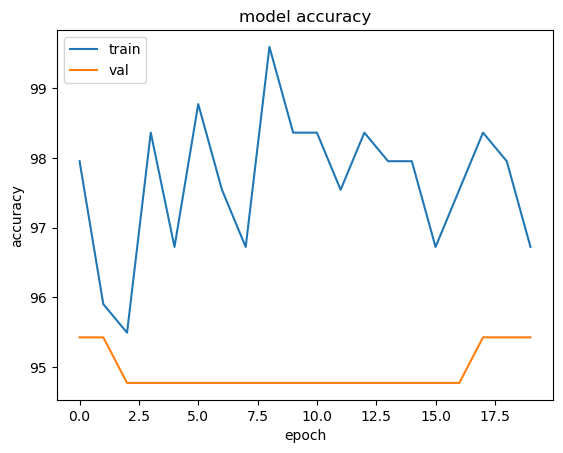

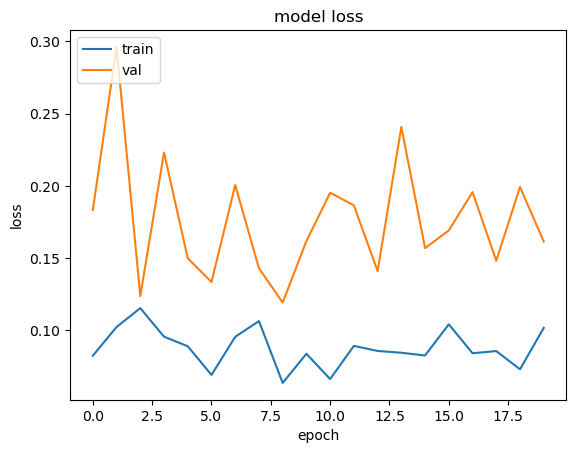

Plots saved.



In [15]:

for run_id, (lr, batch_size, shuffle) in enumerate(product(*parameter_vals)):
    print(f"RUN ID: {run_id+1}, lr:{lr}, bsize:{batch_size}, shuffle:{shuffle}")
    history_dict = {'train loss':[], 'train accuracy':[], 'val loss':[], 'val accuracy':[]}
    writer = SummaryWriter(f'runs/results/r1/batch_size = {batch_size} lr = {lr} shuffle = {shuffle}')
    layout = {
        "Loss and Accuracy (mochi)": {
            "loss": ["Multiline", ["Train Loss", "Val Loss"]],
            "accuracy": ["Multiline", ["Train Accuracy", "Val Accuracy"]],
        },
    }
    writer.add_custom_scalars(layout)

    dataloader = {a: torch.utils.data.DataLoader(dataset=dataset[a], batch_size=batch_size, shuffle=shuffle)
              for a in ['train', 'val']}
    optimizer = torch.optim.SGD(model_resnet18.parameters(), lr=lr, momentum=0.9) # Stochastic gradient descent
    scheduler = StepLR(optimizer, step_size=7, gamma=0.1)

    train_test_loop(
        model_name=f"resnet18_RUNID_{run_id+1}_lr_{lr}_bsize_{batch_size}_shuffle_{shuffle}",
        save=True,
        epochs=epochs,
        model=model_resnet18,
        loss_fn=nn.CrossEntropyLoss(),
        optimizer=optimizer,
        scheduler=scheduler,
        lr=lr,
        batch_size=batch_size,
        shuffle=shuffle,
        run_id=run_id
    )

writer.close()
